In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import PredictionErrorDisplay, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from time import sleep

data_path = './Dataset/'
data = pd.read_csv(data_path + 'hour.csv')

# EDA

In [142]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The following columns are instantly removed, because they either possess no ralationship to the data, like, 'instant', or will have very high correlation, in the example of 'casual' and 'registered' these data points if summed make up target variable.

In [143]:
to_drop = ['instant', 'dteday', 'casual', 'registered']

data = data.drop(to_drop, axis=1)

In [144]:
data.dtypes

season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [145]:
data.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [146]:
data.shape

(17379, 13)

In [147]:
data[data.duplicated()].shape[0]

2

In [148]:
data = data.drop_duplicates()

## Visualizations

<Axes: xlabel='hr', ylabel='count'>

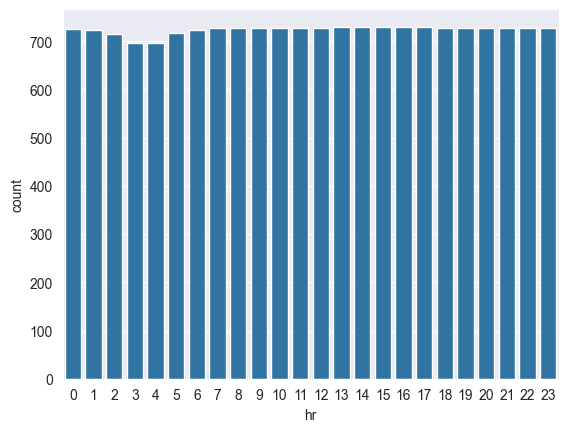

In [149]:
sns.countplot(x='hr', data=data)

<Axes: xlabel='workingday', ylabel='count'>

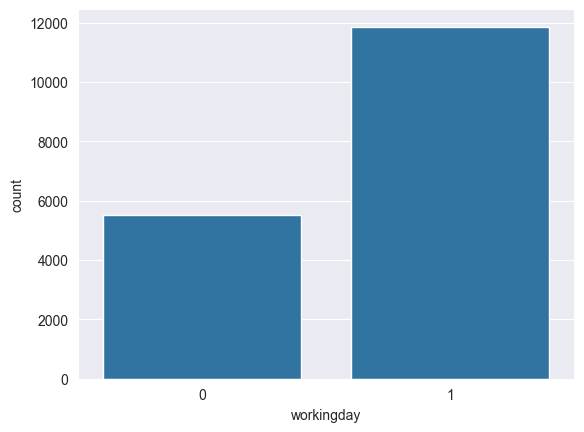

In [150]:
sns.countplot(x='workingday', data=data)

<Axes: xlabel='weekday', ylabel='count'>

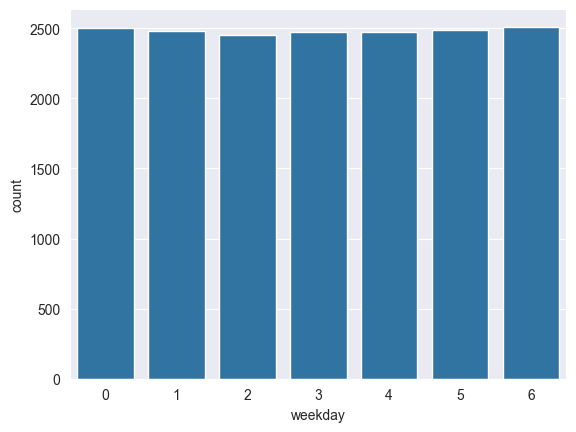

In [151]:
sns.countplot(x='weekday', data=data)

<Axes: xlabel='holiday', ylabel='count'>

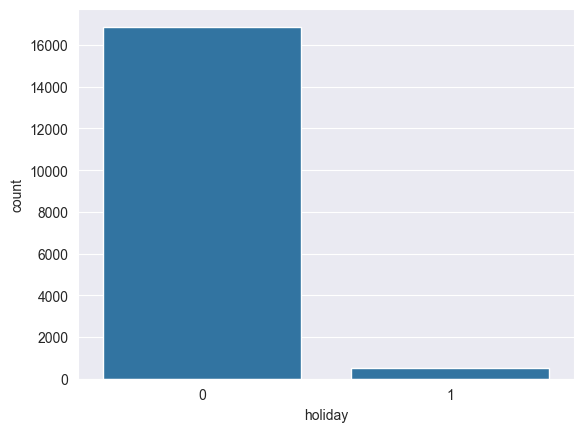

In [152]:
sns.countplot(x='holiday', data=data)

<Axes: xlabel='season', ylabel='count'>

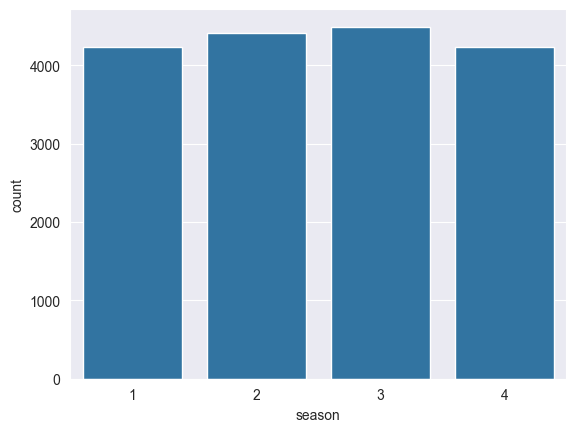

In [153]:
sns.countplot(x='season', data=data)

<Axes: xlabel='windspeed', ylabel='count'>

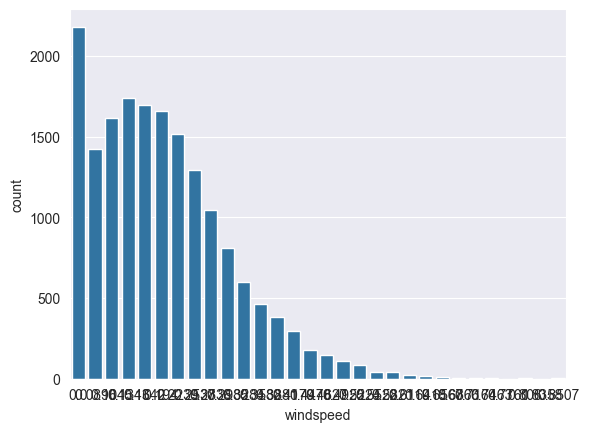

In [154]:
sns.countplot(x='windspeed', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

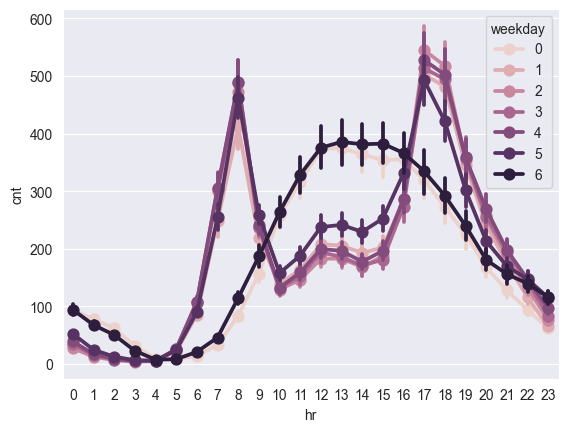

In [155]:
sns.pointplot(x='hr', y='cnt', hue='weekday', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

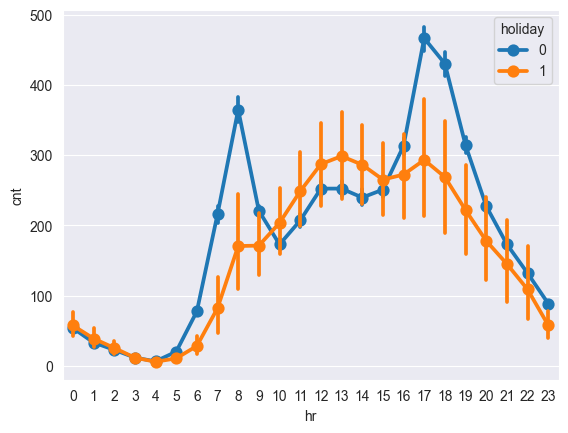

In [156]:
sns.pointplot(x='hr', y='cnt', hue='holiday', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

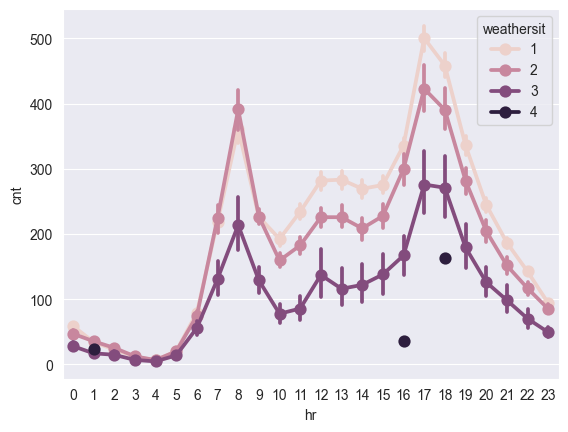

In [157]:
sns.pointplot(x='hr', y='cnt', hue='weathersit', data=data)

<Axes: xlabel='mnth', ylabel='cnt'>

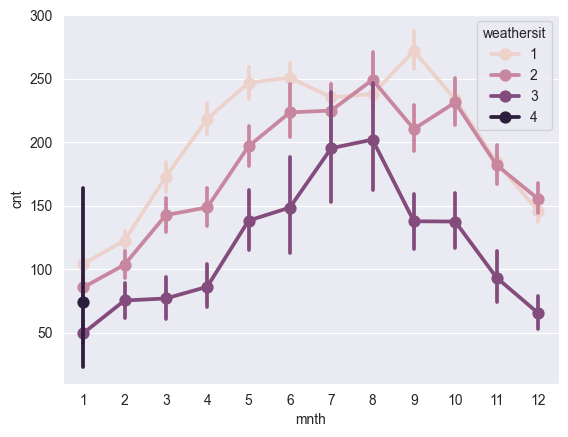

In [158]:
sns.pointplot(y='cnt', x='mnth', hue='weathersit', data=data)

<Axes: xlabel='mnth', ylabel='cnt'>

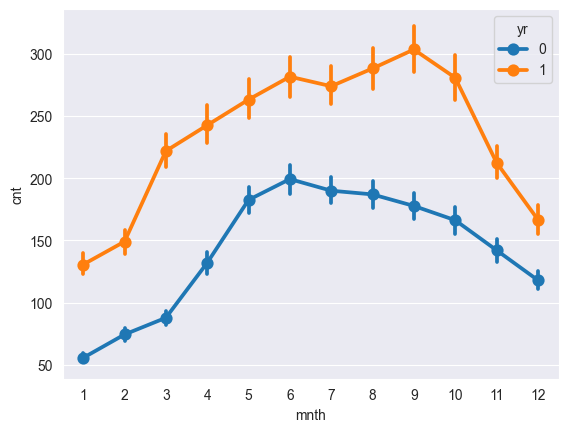

In [159]:
sns.pointplot(x='mnth', y='cnt', hue='yr', data=data)

<Axes: xlabel='windspeed', ylabel='cnt'>

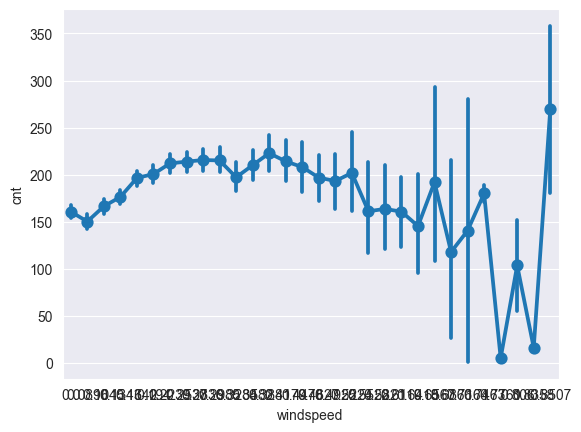

In [160]:
sns.pointplot(x='windspeed', y='cnt', data=data)

## Variable Boxplots

In [161]:
float_features = ['temp', 'hum', 'windspeed', 'atemp']

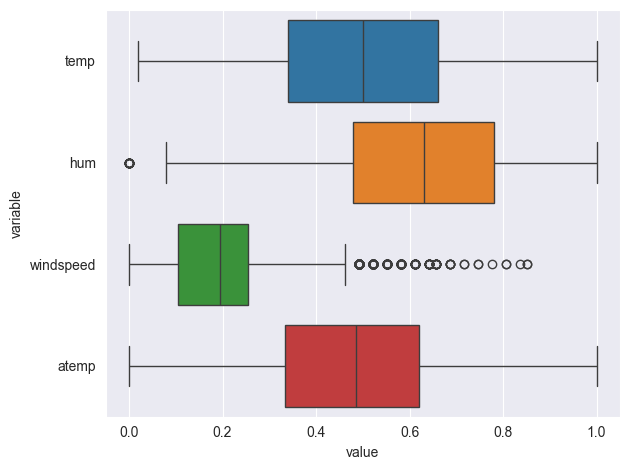

In [162]:
data_long = data.loc[:,float_features].melt()
ax = sns.boxplot(data=data_long, x="value", y="variable", orient="h", hue="variable")
plt.tight_layout()
plt.show()

## Correlation matrix

<Axes: >

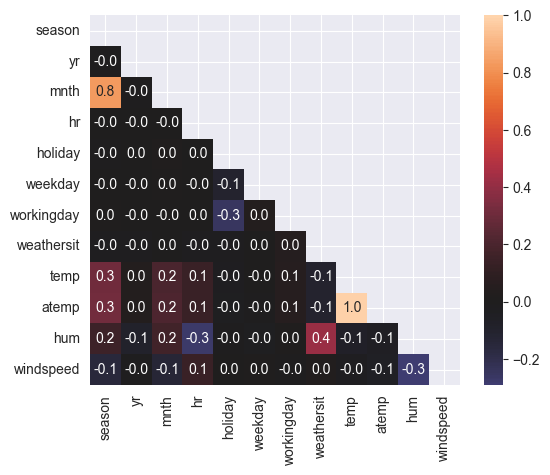

In [163]:
corr = data.loc[:,data.columns!='cnt'].corr(method="pearson")
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    mask = mask,
    vmax=1,
    center=0,
    annot=True,
    fmt='.1f',
    square=True,
)

From correlation matrix it can be seen that there are dependent variables, which should be removed, like
temp and atemp


In [164]:
print(np.corrcoef(data['season'], data['cnt']))

print(np.corrcoef(data['mnth'], data['cnt']))

print(np.corrcoef(data['windspeed'], data['cnt']))

[[1.         0.17817923]
 [0.17817923 1.        ]]
[[1.         0.12075127]
 [0.12075127 1.        ]]
[[1.         0.09315481]
 [0.09315481 1.        ]]


In [165]:
def one_hot_encoder(df,column):
    df = pd.concat([df,pd.get_dummies(df[column],prefix=column, dtype=int)],axis=1)
    df = df.drop(columns = [column],axis=1)
    return df

ohe_columns = ['hr', 'mnth', 'holiday', 'season', 'weekday', 'workingday', 'weathersit']

for col in ohe_columns:
    data[col] = data[col].astype('category')


for col in ohe_columns:
    data = one_hot_encoder(data,col)

In [166]:
data.head()

,yr,temp,atemp,hum,windspeed,cnt,hr_0,hr_1,hr_2,hr_3,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0.24,0.2879,0.81,0.0,16,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,0,0.22,0.2727,0.80,0.0,40,0,1,0,0,...,0,0,0,1,1,0,1,0,0,0
2,0,0.22,0.2727,0.80,0.0,32,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0
3,0,0.24,0.2879,0.75,0.0,13,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
4,0,0.24,0.2879,0.75,0.0,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0


# Model Training

In [167]:
### Custom format MSE
def mse(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.mean((y-y_pred)**2)

def mse(y, y_pred):
    return np.mean((y-y_pred)**2)

In [168]:
y = data.pop('cnt')

X = data.drop(columns=['temp','windspeed'],axis=1)

In [169]:
X.shape

(17377, 58)

In [170]:
X.columns

Index(['yr', 'atemp', 'hum', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5',
       'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13',
       'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21',
       'hr_22', 'hr_23', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'holiday_0', 'holiday_1', 'season_1', 'season_2', 'season_3',
       'season_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'workingday_0', 'workingday_1',
       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [172]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [173]:
mse_score_lr = mse(y_test, y_pred)

print(f'Mean squared error score: {mse_score_lr:.3f}')

Mean squared error score: 10165.833


In [174]:
r2_score_lr = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_lr:.3f}')

R2 score: 0.669


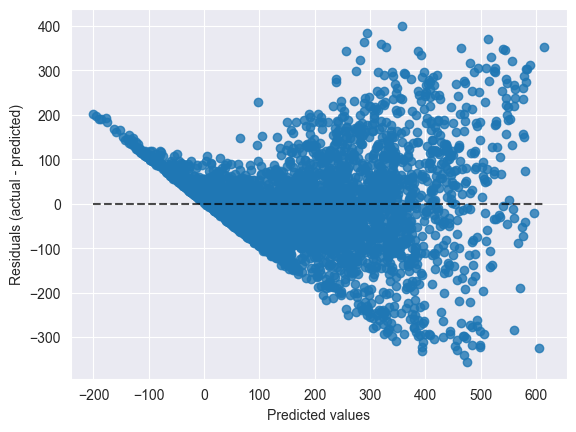

In [175]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

plt.show()

In [176]:
zipp = zip(X.columns, np.abs(lr.coef_))
zipp_df = pd.DataFrame(zipp)

zipp_df.sort_values(by=1, ascending=False).head(10)

,0,1
50,weekday_5,4.003756e+15
48,weekday_3,4.003756e+15
47,weekday_2,4.003756e+15
49,weekday_4,4.003756e+15
46,weekday_1,4.003756e+15
52,workingday_0,3.491624e+15
41,season_1,2.940190e+15
42,season_2,2.940190e+15
43,season_3,2.940190e+15
44,season_4,2.940190e+15


### Applying Standardization to columns with real data values

In [177]:
scaler = StandardScaler()

X_train_scaled = X_train.copy(deep=True)
X_test_scaled = X_test.copy(deep=True)

X_train_scaled['atemp'] = scaler.fit_transform(np.asarray(X_train['atemp']).reshape(-1, 1))
X_test_scaled['atemp'] = scaler.fit_transform(np.asarray(X_test['atemp']).reshape(-1, 1))

X_train_scaled['hum'] = scaler.fit_transform(np.asarray(X_train['hum']).reshape(-1, 1))
X_test_scaled['hum'] = scaler.fit_transform(np.asarray(X_test['hum']).reshape(-1, 1))

In [178]:
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

In [179]:
mse_score_lr_scaled = mse(y_test, y_pred)

print(f'Mean squared error score: {mse_score_lr_scaled:.3f}')

Mean squared error score: 10164.848


In [180]:
r2_score_lr_scaled = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_lr_scaled:.3f}')

R2 score: 0.669


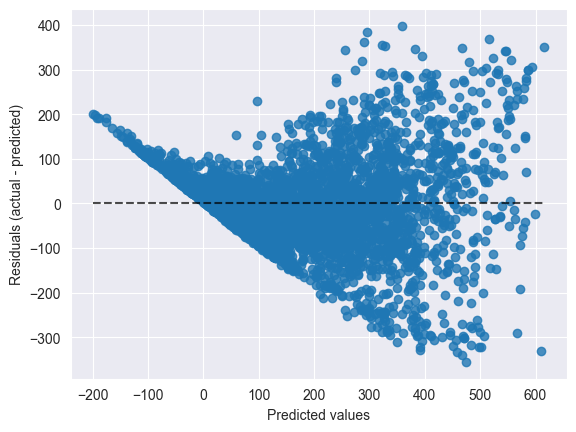

In [181]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

plt.show()

In [182]:
zipp = zip(X.columns, np.abs(lr.coef_))
zipp_df = pd.DataFrame(zipp)

zipp_df.sort_values(by=1, ascending=False).head(10)

,0,1
52,workingday_0,2.106079e+14
45,weekday_0,1.453130e+14
51,weekday_6,1.453130e+14
53,workingday_1,9.768835e+13
39,holiday_0,6.397805e+13
40,holiday_1,4.894148e+13
20,hr_17,3.341609e+13
21,hr_18,3.341609e+13
11,hr_8,3.341609e+13
22,hr_19,3.341609e+13


### Regularization

In [183]:
parameters = {'alpha': np.logspace(-2, 1, base=10)}

lasso_grid = GridSearchCV(Lasso(), parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, refit=True)
lasso_grid.fit(X_train, y_train)

print(f'Best regularization parameter for Lasso was {lasso_grid.best_params_['alpha']:.4f} with MSE score {np.abs(lasso_grid.best_score_):.4f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best regularization parameter for Lasso was 0.0268 with MSE score 10488.4151


In [184]:
lasso_regr = Lasso(**lasso_grid.best_params_)
lasso_regr.fit(X_train, y_train)
y_pred = lasso_regr.predict(X_test)

In [185]:
mse_score_lasso = mse(y_test, y_pred)

print(f'Mean squared error score: {mse_score_lasso:.3f}')

Mean squared error score: 10153.124


In [186]:
r2_score_lasso = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_lasso:.3f}')

R2 score: 0.669


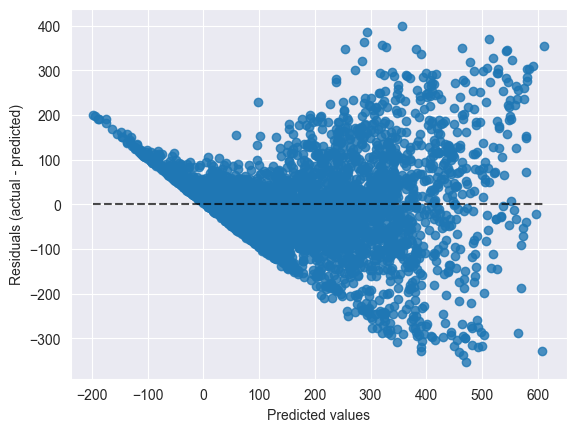

In [187]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

plt.show()

In [188]:
zipp = zip(X.columns, np.abs(lasso_regr.coef_))
zipp_df = pd.DataFrame(zipp)

zipp_df.sort_values(by=1, ascending=False).head(10)

,0,1
1,atemp,240.140254
20,hr_17,231.568683
21,hr_18,194.872151
6,hr_3,189.394908
7,hr_4,187.080184
5,hr_2,177.224822
8,hr_5,173.075968
11,hr_8,172.643369
4,hr_1,164.414611
3,hr_0,149.977109


## SVM

In [189]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [190]:
mse_score_svm = mse(y_test, y_pred)

print(f'Mean squared error score: {mse_score_svm:.3f}')

Mean squared error score: 9558.696


In [191]:
r2_score_svm = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_svm:.3f}')

R2 score: 0.689


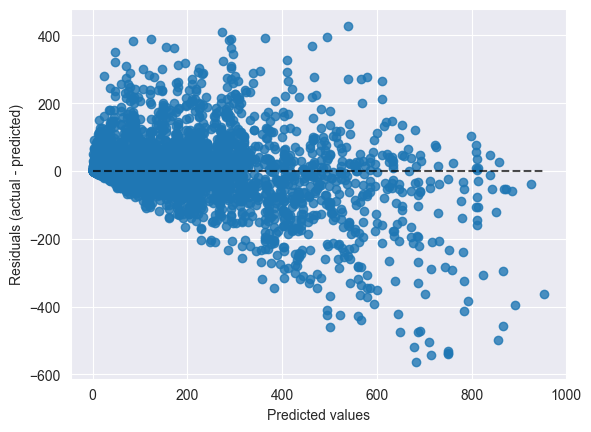

In [192]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

plt.show()

## Random Forest

In [193]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [194]:
mse_score_rf = mse(y_test, y_pred)

print(f'Mean squared error score: {mse_score_rf:.3f}')

Mean squared error score: 2281.401


In [195]:
r2_score_rf = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_rf:.3f}')

R2 score: 0.926


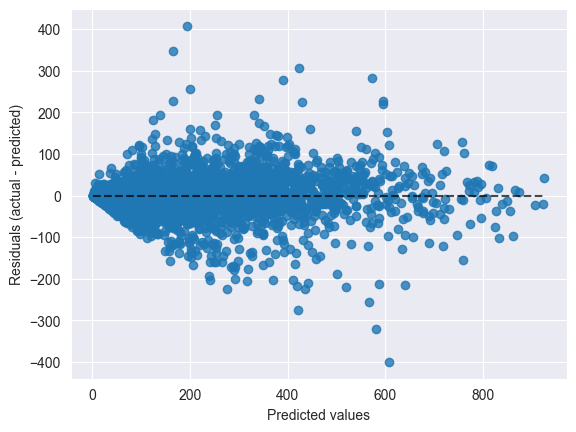

In [196]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

plt.show()

In [197]:
zipp = zip(X.columns, np.abs(rf.feature_importances_))
zipp_df = pd.DataFrame(zipp)
zipp_df.sort_values(by=1, ascending=False).head(10)

,0,1
1,atemp,0.208669
20,hr_17,0.092417
2,hum,0.080363
0,yr,0.079264
21,hr_18,0.078751
11,hr_8,0.063211
52,workingday_0,0.045706
53,workingday_1,0.045693
22,hr_19,0.029638
10,hr_7,0.017178


## Neural Network

In [198]:
X_train_tensor = X_train.astype({col: 'float32' for col in X_train.select_dtypes('bool').columns})
X_test_tensor = X_test.astype({col: 'float32' for col in X_test.select_dtypes('bool').columns})
y_train_tensor = y_train.values
y_test_tensor = y_test.values

scaler = StandardScaler()
X_train_tensor = scaler.fit_transform(X_train_tensor)
X_test_tensor = scaler.transform(X_test_tensor)

X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_tensor, dtype=torch.float32).view(-1, 1)

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input to hidden layer 1
        self.fc2 = nn.Linear(64, 32)         # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(32, 16)         # Hidden layer 2 to hidden layer 3
        self.fc4 = nn.Linear(16, 1)          # Hidden layer 3 to output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the output layer for regression
        return x

input_dim = X_train_tensor.shape[1]
model = RegressionModel(input_dim)

criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        predictions = model(X_batch)  # Forward pass
        loss = criterion(predictions, y_batch)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()
    sleep(0.1)
    tqdm.write(f'Loss {epoch_loss/len(train_loader)}')
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor).item()
    print(f'Test MSE: {test_loss:.4f}')

with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

  1%|          | 1/100 [00:00<01:29,  1.10it/s]

Loss 22133.26850670124


  2%|▏         | 2/100 [00:01<01:15,  1.31it/s]

Loss 5156.218200964216


  3%|▎         | 3/100 [00:02<01:09,  1.40it/s]

Loss 3698.994067242502


  4%|▍         | 4/100 [00:03<01:13,  1.30it/s]

Loss 3008.523445918642


  5%|▌         | 5/100 [00:03<01:11,  1.32it/s]

Loss 2716.0603578764817


  6%|▌         | 6/100 [00:04<01:09,  1.36it/s]

Loss 2535.2477412782864


  7%|▋         | 7/100 [00:05<01:09,  1.34it/s]

Loss 2424.9141130118533


  8%|▊         | 8/100 [00:06<01:09,  1.33it/s]

Loss 2326.4238160582795


  9%|▉         | 9/100 [00:06<01:09,  1.32it/s]

Loss 2250.513946392892


 10%|█         | 10/100 [00:07<01:09,  1.30it/s]

Loss 2184.7976063695446


 11%|█         | 11/100 [00:08<01:07,  1.32it/s]

Loss 2111.9120143846535


 12%|█▏        | 12/100 [00:09<01:07,  1.31it/s]

Loss 2056.343492108926


 13%|█▎        | 13/100 [00:09<01:09,  1.25it/s]

Loss 2009.0539991356861


 14%|█▍        | 14/100 [00:10<01:07,  1.27it/s]

Loss 1954.0238253889413


 15%|█▌        | 15/100 [00:11<01:04,  1.32it/s]

Loss 1921.113097513133


 16%|█▌        | 16/100 [00:12<01:02,  1.34it/s]

Loss 1864.3849628316946


 17%|█▋        | 17/100 [00:12<01:00,  1.38it/s]

Loss 1837.9407343020384


 18%|█▊        | 18/100 [00:13<00:58,  1.41it/s]

Loss 1810.3247729071256


 19%|█▉        | 19/100 [00:14<00:56,  1.43it/s]

Loss 1761.6174286239448


 20%|██        | 20/100 [00:14<00:55,  1.45it/s]

Loss 1730.8953586622217


 21%|██        | 21/100 [00:15<00:54,  1.45it/s]

Loss 1707.7072426280756


 22%|██▏       | 22/100 [00:16<00:53,  1.44it/s]

Loss 1672.658819720389


 23%|██▎       | 23/100 [00:16<00:53,  1.44it/s]

Loss 1650.552069091797


 24%|██▍       | 24/100 [00:17<00:52,  1.45it/s]

Loss 1627.0301364240975


 25%|██▌       | 25/100 [00:18<00:50,  1.47it/s]

Loss 1601.129065713115


 26%|██▌       | 26/100 [00:18<00:50,  1.48it/s]

Loss 1573.378210519374


 27%|██▋       | 27/100 [00:19<00:49,  1.48it/s]

Loss 1565.093087523011


 28%|██▊       | 28/100 [00:20<00:47,  1.50it/s]

Loss 1551.0774783781205


 29%|██▉       | 29/100 [00:20<00:47,  1.50it/s]

Loss 1532.0900794719828


 30%|███       | 30/100 [00:21<00:46,  1.49it/s]

Loss 1518.4710591634114


 31%|███       | 31/100 [00:22<00:46,  1.48it/s]

Loss 1496.4632714984061


 32%|███▏      | 32/100 [00:22<00:45,  1.48it/s]

Loss 1475.1377951435659


 33%|███▎      | 33/100 [00:23<00:45,  1.48it/s]

Loss 1469.0120148055855


 34%|███▍      | 34/100 [00:24<00:44,  1.49it/s]

Loss 1448.529435572131


 35%|███▌      | 35/100 [00:24<00:44,  1.47it/s]

Loss 1431.021428391029


 36%|███▌      | 36/100 [00:25<00:42,  1.49it/s]

Loss 1421.6737524975306


 37%|███▋      | 37/100 [00:26<00:42,  1.47it/s]

Loss 1410.8193076648931


 38%|███▊      | 38/100 [00:27<00:43,  1.42it/s]

Loss 1392.5676384586027


 39%|███▉      | 39/100 [00:27<00:43,  1.39it/s]

Loss 1373.3604415718166


 40%|████      | 40/100 [00:28<00:44,  1.34it/s]

Loss 1369.516119454921


 41%|████      | 41/100 [00:29<00:42,  1.39it/s]

Loss 1348.3283072636045


 42%|████▏     | 42/100 [00:29<00:40,  1.43it/s]

Loss 1328.5570790257948


 43%|████▎     | 43/100 [00:30<00:38,  1.46it/s]

Loss 1326.84784160044


 44%|████▍     | 44/100 [00:31<00:37,  1.49it/s]

Loss 1319.6398447321749


 45%|████▌     | 45/100 [00:31<00:36,  1.49it/s]

Loss 1310.7152660852191


 46%|████▌     | 46/100 [00:32<00:35,  1.50it/s]

Loss 1287.570510197782


 47%|████▋     | 47/100 [00:33<00:35,  1.51it/s]

Loss 1286.3130138879535


 48%|████▊     | 48/100 [00:33<00:34,  1.52it/s]

Loss 1266.1155088928924


 49%|████▉     | 49/100 [00:34<00:33,  1.52it/s]

Loss 1287.0954819251751


 50%|█████     | 50/100 [00:35<00:34,  1.45it/s]

Loss 1258.6092811672167


 51%|█████     | 51/100 [00:35<00:33,  1.46it/s]

Loss 1236.8626552187163


 52%|█████▏    | 52/100 [00:36<00:32,  1.47it/s]

Loss 1232.735473562657


 53%|█████▎    | 53/100 [00:37<00:31,  1.49it/s]

Loss 1233.5038709267803


 54%|█████▍    | 54/100 [00:37<00:30,  1.51it/s]

Loss 1229.8363643251616


 55%|█████▌    | 55/100 [00:38<00:29,  1.51it/s]

Loss 1218.0887287709904


 56%|█████▌    | 56/100 [00:39<00:28,  1.52it/s]

Loss 1206.1845697863348


 57%|█████▋    | 57/100 [00:39<00:28,  1.52it/s]

Loss 1197.9127594344918


 58%|█████▊    | 58/100 [00:40<00:27,  1.53it/s]

Loss 1210.0154391584724


 59%|█████▉    | 59/100 [00:41<00:26,  1.53it/s]

Loss 1192.6295172329608


 60%|██████    | 60/100 [00:41<00:26,  1.53it/s]

Loss 1187.3121887557809


 61%|██████    | 61/100 [00:42<00:25,  1.53it/s]

Loss 1166.1702080386808


 62%|██████▏   | 62/100 [00:43<00:25,  1.52it/s]

Loss 1163.5412514872935


 63%|██████▎   | 63/100 [00:43<00:24,  1.53it/s]

Loss 1153.6942945458422


 64%|██████▍   | 64/100 [00:44<00:23,  1.53it/s]

Loss 1148.4739564040613


 65%|██████▌   | 65/100 [00:45<00:23,  1.52it/s]

Loss 1144.4093507262482


 66%|██████▌   | 66/100 [00:45<00:22,  1.49it/s]

Loss 1133.8116772531093


 67%|██████▋   | 67/100 [00:46<00:22,  1.50it/s]

Loss 1133.4104174383756


 68%|██████▊   | 68/100 [00:47<00:21,  1.51it/s]

Loss 1136.470814742165


 69%|██████▉   | 69/100 [00:47<00:20,  1.52it/s]

Loss 1133.805555356782


 70%|███████   | 70/100 [00:48<00:19,  1.53it/s]

Loss 1117.2579009308213


 71%|███████   | 71/100 [00:49<00:18,  1.53it/s]

Loss 1113.5100146764996


 72%|███████▏  | 72/100 [00:49<00:18,  1.53it/s]

Loss 1097.5668403713182


 73%|███████▎  | 73/100 [00:50<00:17,  1.53it/s]

Loss 1101.5900996416465


 74%|███████▍  | 74/100 [00:51<00:16,  1.54it/s]

Loss 1100.6176874270384


 75%|███████▌  | 75/100 [00:51<00:16,  1.53it/s]

Loss 1089.5287977898258


 76%|███████▌  | 76/100 [00:52<00:15,  1.54it/s]

Loss 1080.6712482671628


 77%|███████▋  | 77/100 [00:53<00:14,  1.54it/s]

Loss 1080.2568060513202


 78%|███████▊  | 78/100 [00:53<00:14,  1.54it/s]

Loss 1068.4038414264548


 79%|███████▉  | 79/100 [00:54<00:13,  1.54it/s]

Loss 1065.097075188297


 80%|████████  | 80/100 [00:54<00:13,  1.53it/s]

Loss 1048.1261556691136


 81%|████████  | 81/100 [00:55<00:12,  1.54it/s]

Loss 1055.7731247825184


 82%|████████▏ | 82/100 [00:56<00:11,  1.54it/s]

Loss 1053.3906902444774


 83%|████████▎ | 83/100 [00:56<00:11,  1.53it/s]

Loss 1052.7510676592246


 84%|████████▍ | 84/100 [00:57<00:10,  1.53it/s]

Loss 1038.7842524912166


 85%|████████▌ | 85/100 [00:58<00:09,  1.54it/s]

Loss 1039.3962598077183


 86%|████████▌ | 86/100 [00:58<00:09,  1.54it/s]

Loss 1033.46262754243


 87%|████████▋ | 87/100 [00:59<00:08,  1.51it/s]

Loss 1028.557685624046


 88%|████████▊ | 88/100 [01:00<00:07,  1.52it/s]

Loss 1025.5495063869432


 89%|████████▉ | 89/100 [01:00<00:07,  1.53it/s]

Loss 1021.7012872805541


 90%|█████████ | 90/100 [01:01<00:06,  1.54it/s]

Loss 1017.0070849188443


 91%|█████████ | 91/100 [01:02<00:05,  1.52it/s]

Loss 1019.9828754293508


 92%|█████████▏| 92/100 [01:02<00:05,  1.53it/s]

Loss 1008.5718975549456


 93%|█████████▎| 93/100 [01:03<00:04,  1.52it/s]

Loss 997.1552160854998


 94%|█████████▍| 94/100 [01:04<00:03,  1.53it/s]

Loss 996.7644041214866


 95%|█████████▌| 95/100 [01:04<00:03,  1.49it/s]

Loss 1000.3250693836432


 96%|█████████▌| 96/100 [01:05<00:02,  1.50it/s]

Loss 986.9553472058526


 97%|█████████▋| 97/100 [01:06<00:01,  1.51it/s]

Loss 984.6067556446997


 98%|█████████▊| 98/100 [01:06<00:01,  1.52it/s]

Loss 978.5071558809829


 99%|█████████▉| 99/100 [01:07<00:00,  1.52it/s]

Loss 975.4017708964732


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]

Loss 978.3996705504669
Test MSE: 1746.5148


In [199]:
y_pred = y_pred.flatten()

In [200]:
residual = y_test-y_pred

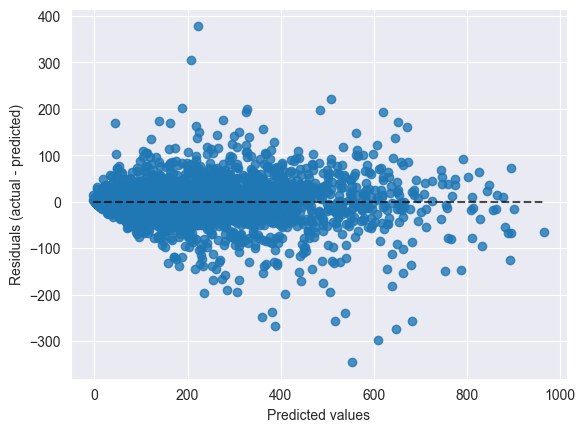

In [201]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

plt.show()